In [1]:
# https://github.com/Suzehva/time_in_language_models_current/blob/main/ii_accuracy/ii_accuracy.py

In [2]:
import numpy as np
import random
import torch

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(0)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Create all prompts where interchanging should cause the model to switch tenses (past/present/future)

In [3]:
# from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer

model_id = "EleutherAI/pythia-1.4b-deduped-v0"
revision = None

USER = 'aditijb'

DATA_DIR = f'/nlp/scr/{USER}/data'
MODEL_DIR = f'/nlp/scr/{USER}/models'


## Heatmap with one prompt
    

In [ ]:
import pandas as pd
import pyvene
from pyvene import embed_to_distrib, top_vals, format_token
from pyvene import RepresentationConfig, IntervenableConfig, IntervenableModel
from pyvene import VanillaIntervention

%config InlineBackend.figure_formats = ['svg']
from plotnine import (
    ggplot,
    geom_tile,
    aes,
    facet_wrap,
    theme,
    element_text,
    geom_bar,
    geom_hline,
    scale_y_log10,
)

 
config, tokenizer, pythia = pyvene.create_gpt_neox(name="EleutherAI/pythia-1.4b-deduped-v0")


nnsight is not detected. Please install via 'pip install nnsight' for nnsight backend.
loaded model


In [5]:
print("pythia.config.num_hidden_layers", pythia.config.num_hidden_layers)

pythia.config.num_hidden_layers 24


### Check how years are tokenized!!

In [12]:
import torch

# Define years and batch size
years = list(range(1700, 2200))
batch_size = 64  # adjust depending on GPU memory

# Make sure the tokenizer has a pad token
tokenizer.pad_token = tokenizer.eos_token

# Precompute year token lengths (without space)
year_token_lengths = {year: len(tokenizer(str(year)).input_ids) for year in years}

# Lists to store results
past_1token_lt2020 = []
future_1token_gt2020 = []
past_2token_lt2020 = []
future_2token_gt2020 = []

# Process in batches
for i in range(0, len(years), batch_size):
    batch_years = years[i:i+batch_size]
    prompts = [f"In {year} there" for year in batch_years]
    
    # Tokenize batch with padding
    inputs = tokenizer(prompts, return_tensors="pt", padding=True)
    
    # Run model once for the batch
    with torch.no_grad():
        outputs = pythia(**inputs)
        logits = outputs.logits  # [batch, seq_len, vocab_size]
        last_logits = logits[:, -1, :]
        probs = torch.softmax(last_logits, dim=-1)
        next_token_ids = torch.argmax(probs, dim=-1)
    
    # Decode and categorize
    for year, next_id in zip(batch_years, next_token_ids):
        next_token = tokenizer.decode([next_id.item()]).strip().lower()
        n_tokens = year_token_lengths[year]

        # Get tokenization with leading space
        year_ids_with_space = tokenizer(" " + str(year)).input_ids
        decoded_with_space = tokenizer.decode(year_ids_with_space)
        
        # Optional: print tokenization info
        print(f"Year: {year}, Tokens with space: {year_ids_with_space}, Decoded: '{decoded_with_space}'")
        
        # Categorize
        if next_token in ["was", "were"]:
            if n_tokens == 1 and year < 2020:
                past_1token_lt2020.append(year)
            elif n_tokens == 2 and year < 2020:
                past_2token_lt2020.append(year)
        elif next_token == "will":
            if n_tokens == 1 and year > 2020:
                future_1token_gt2020.append(year)
            elif n_tokens == 2 and year > 2020:
                future_2token_gt2020.append(year)

# Print results
print("Past (<2020) predicting 1 token:", past_1token_lt2020)
print("Future (>2020) predicting 1 token:", future_1token_gt2020)
print("Past (<2020) predicting 2 tokens:", past_2token_lt2020)
print("Future (>2020) predicting 2 tokens:", future_2token_gt2020)


Year: 1700, Tokens with space: [1722, 361], Decoded: ' 1700'
Year: 1701, Tokens with space: [1722, 520], Decoded: ' 1701'
Year: 1702, Tokens with space: [1722, 2640], Decoded: ' 1702'
Year: 1703, Tokens with space: [1722, 2941], Decoded: ' 1703'
Year: 1704, Tokens with space: [1722, 2125], Decoded: ' 1704'
Year: 1705, Tokens with space: [1722, 1762], Decoded: ' 1705'
Year: 1706, Tokens with space: [1722, 3071], Decoded: ' 1706'
Year: 1707, Tokens with space: [1722, 2922], Decoded: ' 1707'
Year: 1708, Tokens with space: [1722, 2904], Decoded: ' 1708'
Year: 1709, Tokens with space: [1722, 2693], Decoded: ' 1709'
Year: 1710, Tokens with space: [1722, 740], Decoded: ' 1710'
Year: 1711, Tokens with space: [1722, 883], Decoded: ' 1711'
Year: 1712, Tokens with space: [1722, 805], Decoded: ' 1712'
Year: 1713, Tokens with space: [1722, 1012], Decoded: ' 1713'
Year: 1714, Tokens with space: [1722, 1047], Decoded: ' 1714'
Year: 1715, Tokens with space: [1722, 1010], Decoded: ' 1715'
Year: 1716, T

In [13]:
import torch

# Define the same years
years = list(range(1700, 2200))
batch_size = 64

# Make sure the tokenizer has a pad token
tokenizer.pad_token = tokenizer.eos_token

print(f"{'Year':<6} {'Token IDs':<25} {'Decoded Tokens':<25} {'#Tokens':<8} {'Next Token':<10}")

for i in range(0, len(years), batch_size):
    batch_years = years[i:i+batch_size]
    prompts = [f"In {year} there" for year in batch_years]
    
    # Tokenize batch
    inputs = tokenizer(prompts, return_tensors="pt", padding=True)
    
    # Run model once for the batch
    with torch.no_grad():
        outputs = pythia(**inputs)
        logits = outputs.logits
        last_logits = logits[:, -1, :]
        next_token_ids = torch.argmax(torch.softmax(last_logits, dim=-1), dim=-1)
    
    # Print year info with a leading space
    for year, next_id in zip(batch_years, next_token_ids):
        year_ids = tokenizer(" " + str(year)).input_ids  # <-- add leading space
        decoded_year_tokens = [tokenizer.decode([tid]).strip() for tid in year_ids]
        n_tokens = len(year_ids)
        next_token = tokenizer.decode([next_id.item()]).strip()
        print(f"{year:<6} {year_ids!s:<25} {decoded_year_tokens!s:<25} {n_tokens:<8} {next_token:<10}")


Year   Token IDs                 Decoded Tokens            #Tokens  Next Token
1700   [1722, 361]               ['17', '00']              2        were      
1701   [1722, 520]               ['17', '01']              2        was       
1702   [1722, 2640]              ['17', '02']              2        was       
1703   [1722, 2941]              ['17', '03']              2        was       
1704   [1722, 2125]              ['17', '04']              2        was       
1705   [1722, 1762]              ['17', '05']              2        was       
1706   [1722, 3071]              ['17', '06']              2        was       
1707   [1722, 2922]              ['17', '07']              2        was       
1708   [1722, 2904]              ['17', '08']              2        was       
1709   [1722, 2693]              ['17', '09']              2        was       
1710   [1722, 740]               ['17', '10']              2        was       
1711   [1722, 883]               ['17', '11']       

### Check how years are tokenized!!

In [15]:
BASE_PROMPT = "In 1883 there"
SOURCE_PROMPT = "In 2023 there"

base = tokenizer("In 1883 there", return_tensors="pt")
sources = [tokenizer("In 2023 there", return_tensors="pt")]
tokens = tokenizer.encode(" was will")
data = []

def simple_position_config(model_type, component, layer):
    config = IntervenableConfig(
        model_type=model_type,
        representations=[
            RepresentationConfig(
                layer,              # layer
                component,          # component
                "pos",              # intervention unit
                1,                  # max number of unit
            ),
        ],
        intervention_types=VanillaIntervention,
    )
    return config


In [ ]:
import torch
import torch.nn.functional as F

source = sources[0]
for sentence in [base, source]:

    # Get model logits
    with torch.no_grad():
        outputs = pythia(**sentence)
        logits = outputs.logits  # [batch, seq_len, vocab_size]

    # Take the last token's logits (next-token prediction)
    last_logits = logits[0, -1]
    probs = F.softmax(last_logits, dim=-1)

    next_token_id = torch.argmax(probs).item()
    next_token_prob = probs[next_token_id].item()

    # Decode sentence and next token
    decoded_sentence = tokenizer.decode(sentence.input_ids[0])
    tokenized_ids = sentence.input_ids[0].tolist()
    next_token = tokenizer.decode([next_token_id])

    print("Sentence (decoded):", decoded_sentence)
    print("Tokenized IDs:    ", tokenized_ids)
    print(f"Next token: {next_token} (prob={next_token_prob:.4f})")
    print()


# Sentence (decoded): In 1883 there
# Tokenized IDs:     [688, 1283, 3245, 627]
# Next token:  was (prob=0.5434)

# Sentence (decoded): In 2023 there
# Tokenized IDs:     [688, 1384, 1508, 627]
# Next token:  will (prob=0.6674)


Sentence (decoded): In 1883 there
Tokenized IDs:     [688, 1283, 3245, 627]
Next token:  was (prob=0.5434)

Sentence (decoded): In 2023 there
Tokenized IDs:     [688, 1384, 1508, 627]
Next token:  will (prob=0.6674)



In [23]:
# do intervention gathering of hidden layers :)

for layer_i in range(pythia.config.num_hidden_layers):
    config = simple_position_config(type(pythia), "block_output", layer_i) # TODO don't use MLP
    intervenable = IntervenableModel(config, pythia)
    for pos_i in range(len(base.input_ids[0])):
        
        _, counterfactual_outputs = intervenable(
            base, sources, {"sources->base": pos_i}
        )
        logits = counterfactual_outputs.logits
        distrib = torch.softmax(logits, dim=-1)
        intervention_token_id = base.input_ids[0][pos_i].item()
        intervention_token = format_token(tokenizer, intervention_token_id)
        

        for token in tokens:
            data.append(
                {
                    "token": format_token(tokenizer, token),
                    "prob": float(distrib[0][-1][token]),
                    "layer": f"f{layer_i}",
                    "pos": pos_i,
                    "intervention_token": intervention_token,  # Added this line
                    "type": "block_output",
                }
            )

df = pd.DataFrame(data)


KeyboardInterrupt: 

Base tokens: ['In', '_18', '83', '_there']
Source tokens: ['In', '_20', '23', '_there']


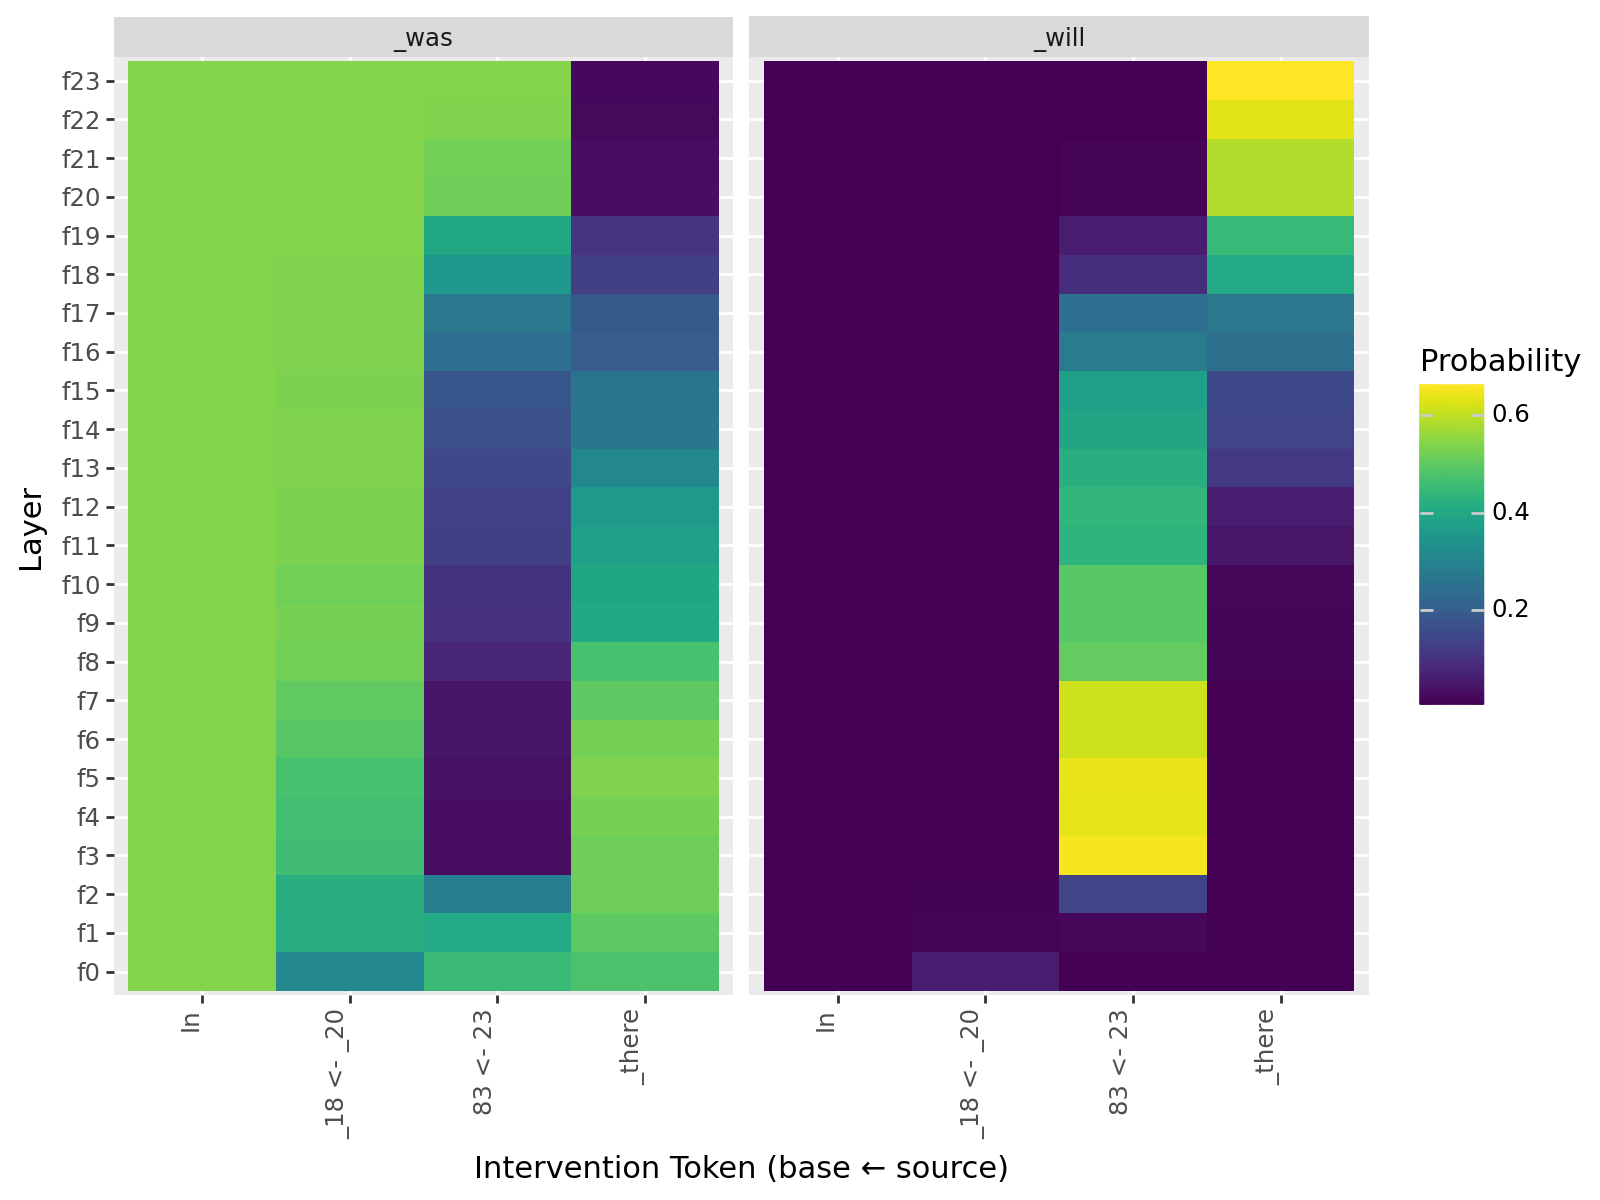

In [24]:
# aditi wrote

import torch
import pandas as pd
from plotnine import ggplot, aes, geom_tile, facet_wrap, theme, element_text, labs, options

# Base and source prompts
base_prompt = BASE_PROMPT
source_prompt = SOURCE_PROMPT

# Tokenize both
base_ids = base.input_ids[0]
source_ids = sources[0].input_ids[0]

base_tokens = [format_token(tokenizer, tid.item()) for tid in base_ids]
source_tokens = [format_token(tokenizer, tid.item()) for tid in source_ids]

print("Base tokens:", base_tokens)
print("Source tokens:", source_tokens)

# Make x-axis labels: normally base token, but show swapped token for differences
x_labels = []
for b_tok, s_tok in zip(base_tokens, source_tokens):
    if b_tok != s_tok:
        x_labels.append(f"{b_tok} <- {s_tok}")
    else:
        x_labels.append(b_tok)

# Map df intervention tokens to these labels
df["intervention_token_label"] = pd.Categorical(
    [x_labels[pos] for pos in df["pos"]],
    categories=x_labels,
    ordered=True
)

# Layers categorical (0 at bottom, max at top)
df["layer"] = pd.Categorical(df["layer"], categories=[f"f{l}" for l in range(pythia.config.num_hidden_layers)], ordered=True)

# Token categorical
df["token"] = df["token"].astype("category")

# Plot
g = (
    ggplot(df)
    + geom_tile(aes(x="intervention_token_label", y="layer", fill="prob"), raster=False)
    + facet_wrap("~token")
    + theme(axis_text_x=element_text(rotation=90, ha='right'))
    + labs(x="Intervention Token (base ← source)", y="Layer", fill="Probability")
)

# Optional figure size
options.figure_size = (12, 6)

g


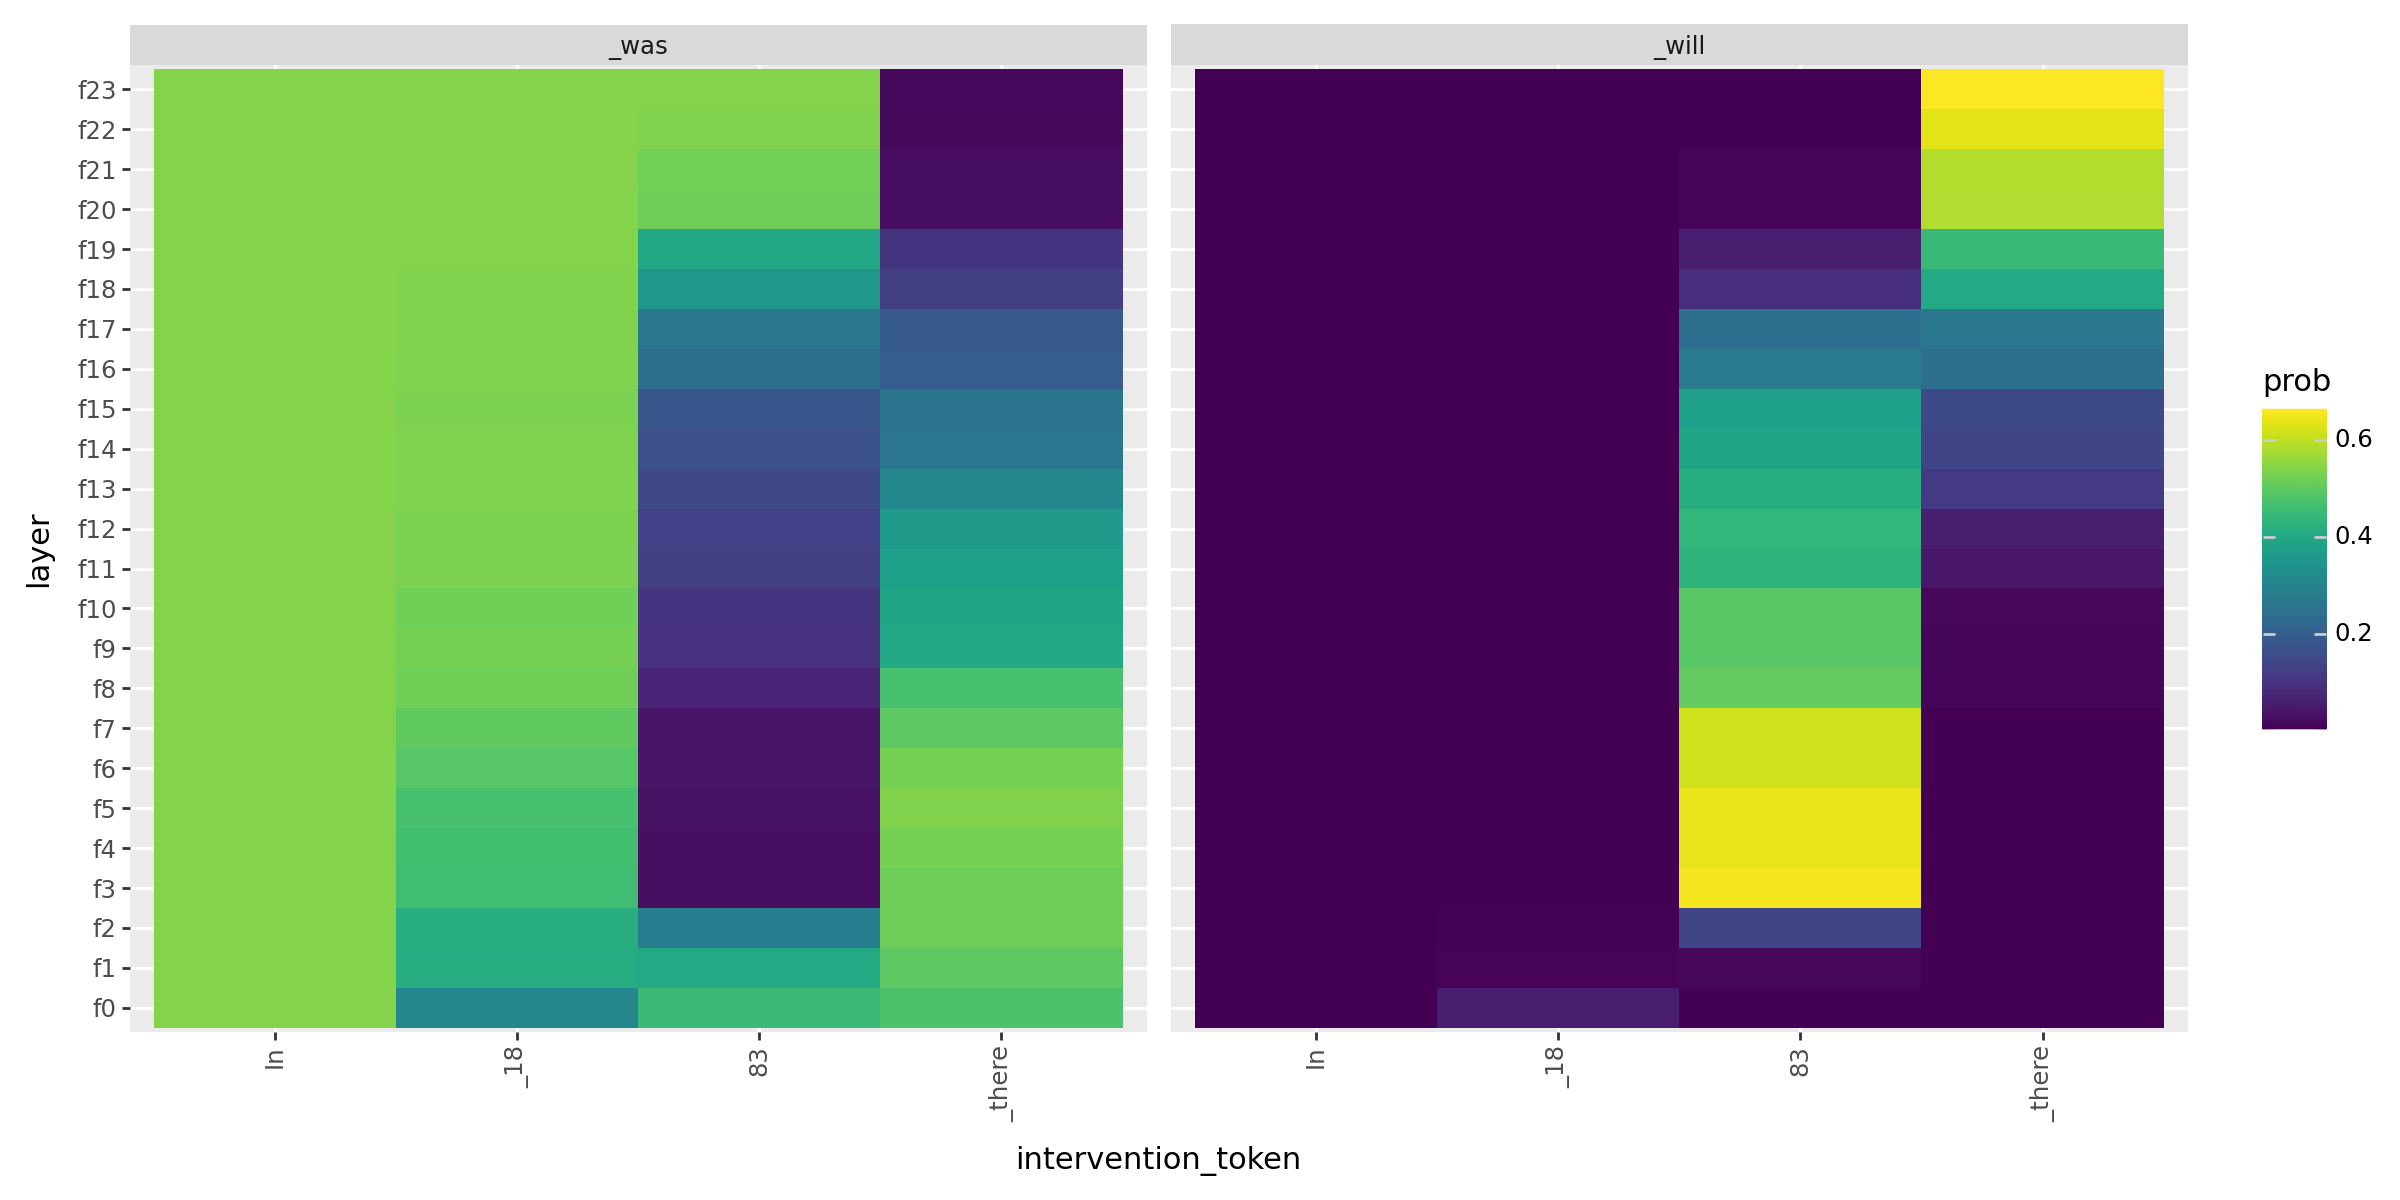

In [21]:
import torch
from plotnine import options

df["layer"] = df["layer"].astype("category")
df["token"] = df["token"].astype("category")

# layers with 0 at bottom, 15 at top
layer_nodes = [f"f{l}" for l in range(pythia.config.num_hidden_layers)]
df["layer"] = pd.Categorical(df["layer"], categories=layer_nodes, ordered=True)

# Order intervention tokens by their position in the sentence
intervention_token_order = []
for pos_i in range(len(base.input_ids[0])):
    intervention_token_id = base.input_ids[0][pos_i].item()
    intervention_token = format_token(tokenizer, intervention_token_id)
    intervention_token_order.append(intervention_token)

df["intervention_token"] = pd.Categorical(
    df["intervention_token"],
    categories=intervention_token_order,
    ordered=True
)

g = (
    ggplot(df)
    + geom_tile(aes(x="intervention_token", y="layer", fill="prob"), raster=False)
    + facet_wrap("~token")
    + theme(axis_text_x=element_text(rotation=90))
)

options.figure_size = (8, 6)  # optional
g
